# Cats & Dogs Image Classification Model

## 1. Setup imports

In [132]:
# Torch imports
import torch
import torchvision
import torchvision.models as models
import torch.nn as nn
from torchvision import transforms, datasets
from torchinfo import summary
import numpy as np
from PIL import Image
from pathlib import Path
import os
import random
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from typing import List, Dict, Tuple
from tqdm.notebook import tqdm

In [84]:
# Setting up device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

## 2. Load the data

In [85]:
# Setup the path for datafolder
DATAPATH = Path("data")
image_path = DATAPATH / "cats-dogs"

In [86]:
# Exploring data directories

def walk_through_dir(dir_path: Path):
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/cats-dogs'.
There are 2 directories and 0 images in 'data/cats-dogs/train'.
There are 0 directories and 278 images in 'data/cats-dogs/train/dogs'.
There are 0 directories and 279 images in 'data/cats-dogs/train/cats'.
There are 2 directories and 0 images in 'data/cats-dogs/test'.
There are 0 directories and 70 images in 'data/cats-dogs/test/dogs'.
There are 0 directories and 70 images in 'data/cats-dogs/test/cats'.


In [87]:
# Setup train and testing directories
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/cats-dogs/train'), PosixPath('data/cats-dogs/test'))

### 2.1 Visualizing an image

Image path: data/cats-dogs/train/dogs/dog_260.jpg
Image class: dogs
Image size: (630, 558)


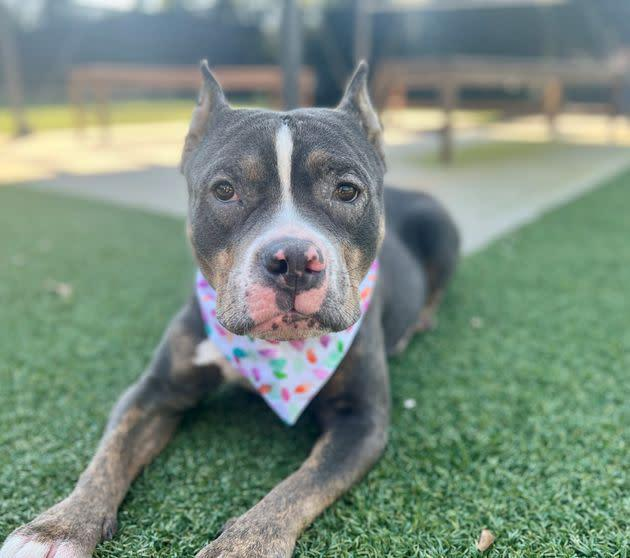

In [88]:
# Get all image paths
image_paths = list(image_path.glob("*/*/*.jpg"))

# Picking random image
random_image_path = random.choice(image_paths)

# Open the image
img = Image.open(random_image_path)

# Getting class name
class_name = random_image_path.parent.name

# Plotting the image and its metadata
print(f"Image path: {random_image_path}")
print(f"Image class: {class_name}")
print(f"Image size: {img.size}")
img

Text(0.5, 1.0, 'Image class: dogs | Image size: (558, 630, 3) -> (H, W, C)')

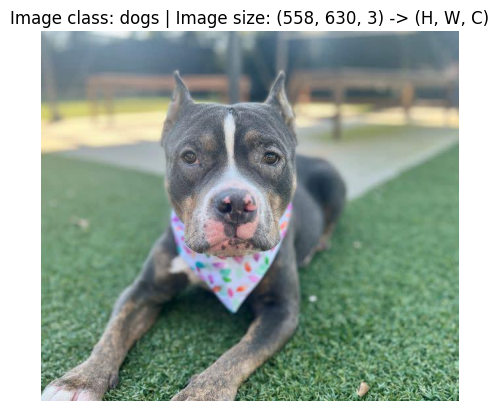

In [89]:
# Turn the image to an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.imshow(img_as_array)
plt.axis(False)
plt.title(f"Image class: {class_name} | Image size: {img_as_array.shape} -> (H, W, C)")

## 3. Transform the data

In [90]:

# Train data transform
train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Test data transform
test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [91]:
# Testing the transforms
transformed_img = train_transform(img)
print(f"Image before transform: {img_as_array.shape} -> (H, W, C)")
print(f"Image type before transformation: {img_as_array.dtype}")
print(f"Image after transform: {transformed_img.shape} -> (C, H, W)")
print(f"Image type after transformation: {transformed_img.dtype}")

Image before transform: (558, 630, 3) -> (H, W, C)
Image type before transformation: uint8
Image after transform: torch.Size([3, 224, 224]) -> (C, H, W)
Image type after transformation: torch.float32


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Transformed Image')

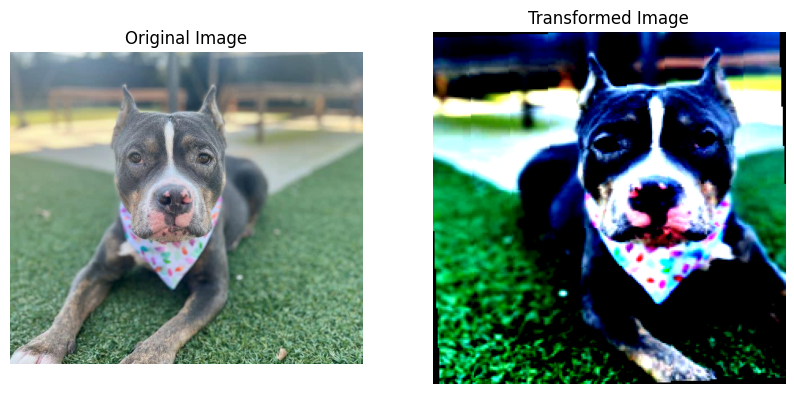

In [92]:
# Plotting the original and transformed image
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(img_as_array)
plt.axis(False)
plt.title("Original Image")

plt.subplot(1, 2, 2)
plt.imshow(transformed_img.permute(1, 2, 0))
plt.axis(False)
plt.title("Transformed Image")


## 4. Loading the data into a Dataset

In [93]:
# Use ImageFolder to create dataset
train_data = datasets.ImageFolder(root=train_dir, transform=train_transform)

test_data = datasets.ImageFolder(root=test_dir, transform=test_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 557
     Root location: data/cats-dogs/train
     StandardTransform
 Transform: Compose(
                Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
                RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
                RandomHorizontalFlip(p=0.5)
                RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
                ColorJitter(brightness=(0.9, 1.1), contrast=(0.9, 1.1), saturation=(0.9, 1.1), hue=(-0.1, 0.1))
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ),
 Dataset ImageFolder
     Number of datapoints: 140
     Root location: data/cats-dogs/test
     StandardTransform
 Transform: Compose(
                Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
                CenterCrop(size=(224, 224

In [95]:
# Getting the class names as list
class_names = train_data.classes

# Getting the class names as dict
class_names_dict = train_data.class_to_idx


class_names, class_names_dict

(['cats', 'dogs'], {'cats': 0, 'dogs': 1})

In [96]:
# Checking length of train and test data
len(train_data), len(test_data)

(557, 140)

## 4. Creating DataLoaders

In [97]:
# Setting the batch size
BATCH_SIZE = 32

# Setting the num_workers
NUM_WORKERS = os.cpu_count()

# Creating data loaders
train_loader = torch.utils.data.DataLoader(train_data,
                                           batch_size=BATCH_SIZE,
                                           shuffle=True,
                                           num_workers=NUM_WORKERS)

test_loader = torch.utils.data.DataLoader(test_data,
                                            batch_size=BATCH_SIZE,
                                            shuffle=False,
                                            num_workers=NUM_WORKERS)
len(train_loader), len(test_loader)                  

(18, 5)

In [99]:
# Getting the first batch
img, label = next(iter(train_loader))

# Checking the shape of the image and label
print(f"Image batch shape: {img.shape} -> (BATCH, C, H, W)")
print(f"Image label shape: {label.shape} -> (BATCH)")

Image batch shape: torch.Size([32, 3, 224, 224]) -> (BATCH, C, H, W)
Image label shape: torch.Size([32]) -> (BATCH)


## 5. Creating the model

In [100]:
# Loading the pre-trained model
model = models.resnet50(pretrained=True)

# Checking the model architecture
model

/home/felipe/.local/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/felipe/.local/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /home/felipe/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:08<00:00, 11.7MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [104]:
# Freezing the model parameters (only apllying learning to the last layer)
for param in model.parameters():
    param.requires_grad = False

# Changing the last layer to fit our data
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, len(class_names))

# Verifying if CUDA is available (another aproach)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

summary(model=model, input_size=(BATCH_SIZE, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [32, 2]                   --
├─Conv2d: 1-1                            [32, 64, 112, 112]        (9,408)
├─BatchNorm2d: 1-2                       [32, 64, 112, 112]        (128)
├─ReLU: 1-3                              [32, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [32, 64, 56, 56]          --
├─Sequential: 1-5                        [32, 256, 56, 56]         --
│    └─Bottleneck: 2-1                   [32, 256, 56, 56]         --
│    │    └─Conv2d: 3-1                  [32, 64, 56, 56]          (4,096)
│    │    └─BatchNorm2d: 3-2             [32, 64, 56, 56]          (128)
│    │    └─ReLU: 3-3                    [32, 64, 56, 56]          --
│    │    └─Conv2d: 3-4                  [32, 64, 56, 56]          (36,864)
│    │    └─BatchNorm2d: 3-5             [32, 64, 56, 56]          (128)
│    │    └─ReLU: 3-6                    [32, 64, 56, 56]   

## 6. Preparing the training steps

In [108]:
# Creating training function
def training_step(model: nn.Module,
                  dataloader: DataLoader,
                  loss_fn: nn.Module,
                  optimizer: torch.optim.Optimizer,
                  device: str) -> Dict[str, float]:
    
    model.train()
    train_loss, train_accuracy = 0, 0

    # Looping over the training set
    for images, label in dataloader:
        # Send data to device
        images, label = images.to(device), label.to(device)

        # Forward pass
        outputs = model(images)

        # Calculate loss
        loss = loss_fn(outputs, label)
        train_loss += loss.item()

        # Zero the gradients
        optimizer.zero_grad()

        # Backward pass
        loss.backward()

        # Update weights
        optimizer.step()

        # Calculate accuracy
        predictions = outputs.argmax(dim=1)
        train_accuracy += torch.sum(predictions == label).item()/len(predictions)

    # Adjusting metrics
    train_loss /= len(dataloader)
    train_accuracy /= len(dataloader)

    return {"train_loss": train_loss, "train_accuracy": train_accuracy}

In [109]:
# Creating testing function
def testing_step(model: nn.Module,
                  dataloader: DataLoader,
                  loss_fn: nn.Module,
                  device: str) -> Dict[str, float]:
    
    model.eval()
    test_loss, test_accuracy = 0, 0


    # Turning off gradients
    with torch.inference_mode():
        # Looping over the testing set
        for images, label in dataloader:
            # Send data to device
            images, label = images.to(device), label.to(device)

            # Forward pass
            outputs = model(images)

            # Calculate loss
            loss = loss_fn(outputs, label)
            test_loss += loss.item()

            # Calculate accuracy
            predictions = outputs.argmax(dim=1)
            test_accuracy += torch.sum(predictions == label).item()/len(predictions)

    # Adjusting metrics
    test_loss /= len(dataloader)
    test_accuracy /= len(dataloader)

    return {"test_loss": test_loss, "test_accuracy": test_accuracy}

In [111]:
# Function to train the model
def training(model: nn.Module,
             train_loader: DataLoader,
             test_loader: DataLoader,
             loss_fn: nn.Module,
             optimizer: torch.optim.Optimizer,
             device: str,
             epochs: int) -> Dict[str, list]:
    
    # Tracking the metrics
    results = {"train_loss": [], "train_accuracy": [], "test_loss": [], "test_accuracy": []}

    # Training the model
    for epoch in tqdm(range(epochs)):
        # Training step
        train_results = training_step(model, train_loader, loss_fn, optimizer, device)

        # Testing step
        test_results = testing_step(model, test_loader, loss_fn, device)

        # Saving results
        results["train_loss"].append(train_results["train_loss"])
        results["train_accuracy"].append(train_results["train_accuracy"])
        results["test_loss"].append(test_results["test_loss"])
        results["test_accuracy"].append(test_results["test_accuracy"])

        print(f"Epoch: {epoch+1}/{epochs} | Train loss: {train_results['train_loss']:.5f} | Train accuracy: {train_results['train_accuracy']:.5f} | Test loss: {test_results['test_loss']:.5f} | Test accuracy: {test_results['test_accuracy']:.5f}")

    return results

## 7. Training the model

In [112]:
# Setting seeds for reproducibility
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Setting the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Setting the number of epochs
NUM_EPOCHS = 5

# Setting the loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Starting the timer
from time import time
start_time = time()

# Training the model
model_results = training(model, train_loader, test_loader, loss_fn, optimizer, device, NUM_EPOCHS)

# Ending the timer
end_time = time()

# Calculating the total time
total_time = end_time - start_time
print(f"Total time: {total_time//60:.0f}m {total_time%60:.0f}s on {device}")
print(f"Average time per epoch: {total_time/NUM_EPOCHS:.2f}s")
print("Training results: ", model_results)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1/5 | Train loss: 0.59891 | Train accuracy: 0.68323 | Test loss: 0.29526 | Test accuracy: 0.93542
Epoch: 2/5 | Train loss: 0.34279 | Train accuracy: 0.88034 | Test loss: 0.18468 | Test accuracy: 0.96250
Epoch: 3/5 | Train loss: 0.25838 | Train accuracy: 0.90465 | Test loss: 0.18121 | Test accuracy: 0.92500
Epoch: 4/5 | Train loss: 0.22710 | Train accuracy: 0.92107 | Test loss: 0.14149 | Test accuracy: 0.93750
Epoch: 5/5 | Train loss: 0.22566 | Train accuracy: 0.91840 | Test loss: 0.12120 | Test accuracy: 0.94375
Total time: 3m 21s
Average time per epoch: 40.12s
Training results:  {'train_loss': [0.5989069259828992, 0.34278709275854957, 0.2583802044391632, 0.2271037060353491, 0.22565748708115685], 'train_accuracy': [0.6832264957264957, 0.8803418803418803, 0.9046474358974359, 0.921073717948718, 0.9184027777777778], 'test_loss': [0.29525747895240784, 0.18468048125505448, 0.18120888471603394, 0.14148798137903212, 0.12119879424571992], 'test_accuracy': [0.9354166666666666, 0.9625, 0.

## 8. Evaluating the model

In [113]:
# Function to plot the loss curve
def plot_loss_curve(results: Dict[str, list]):
    plt.figure(figsize=(10, 6))
    plt.plot(results["train_loss"], label="Train loss", marker="o")
    plt.plot(results["test_loss"], label="Test loss", marker="o")
    plt.title("Loss curve")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

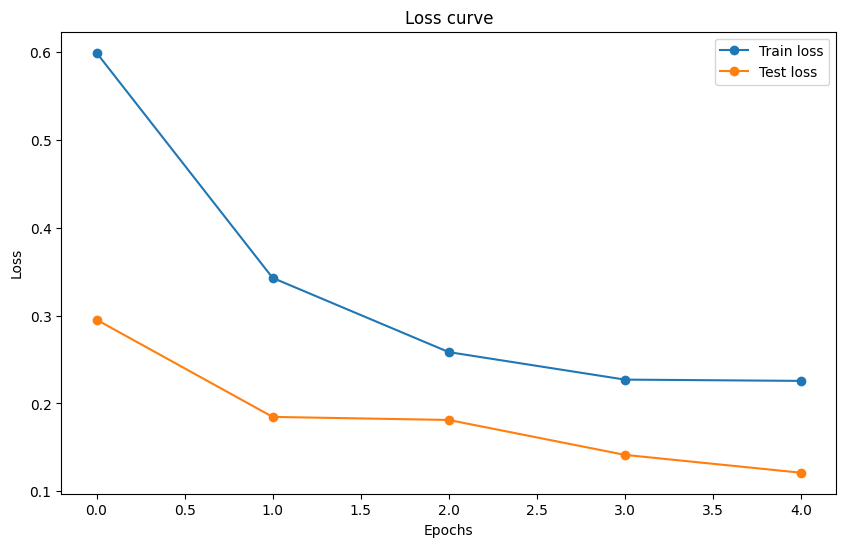

In [114]:
# Plotting
plot_loss_curve(model_results)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 223.5, 223.5, -0.5)

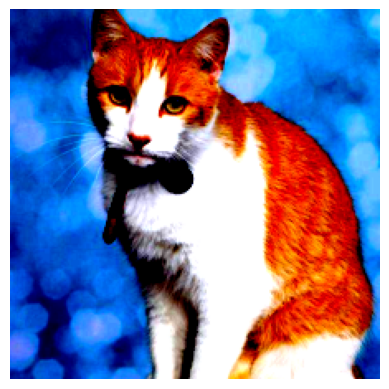

In [122]:
sample_img, label = next(iter(test_loader))

# Plotting the sample image
plt.imshow(sample_img[0].permute(1, 2, 0))
plt.axis(False)

## 9. Plotting a batch of images with predictions

In [127]:
# Function to plot a random batch of images
def plot_random_batch(model: nn.Module, dataloader: DataLoader, class_names: List[str]):
    model.eval()
    images, labels = random.choice(list(iter(dataloader)))
    outputs = model(images.to(device))
    predictions = outputs.argmax(dim=1)
    plt.figure(figsize=(16, 16))
    for i in range(16):
        plt.subplot(4, 4, i+1)
        plt.imshow(images[i].permute(1, 2, 0))
        color = "green" if predictions[i] == labels[i] else "red"
        plt.title(f"Actual: {class_names[labels[i]]} | Predicted: {class_names[predictions[i]]}", color=color)
        plt.axis(False)
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

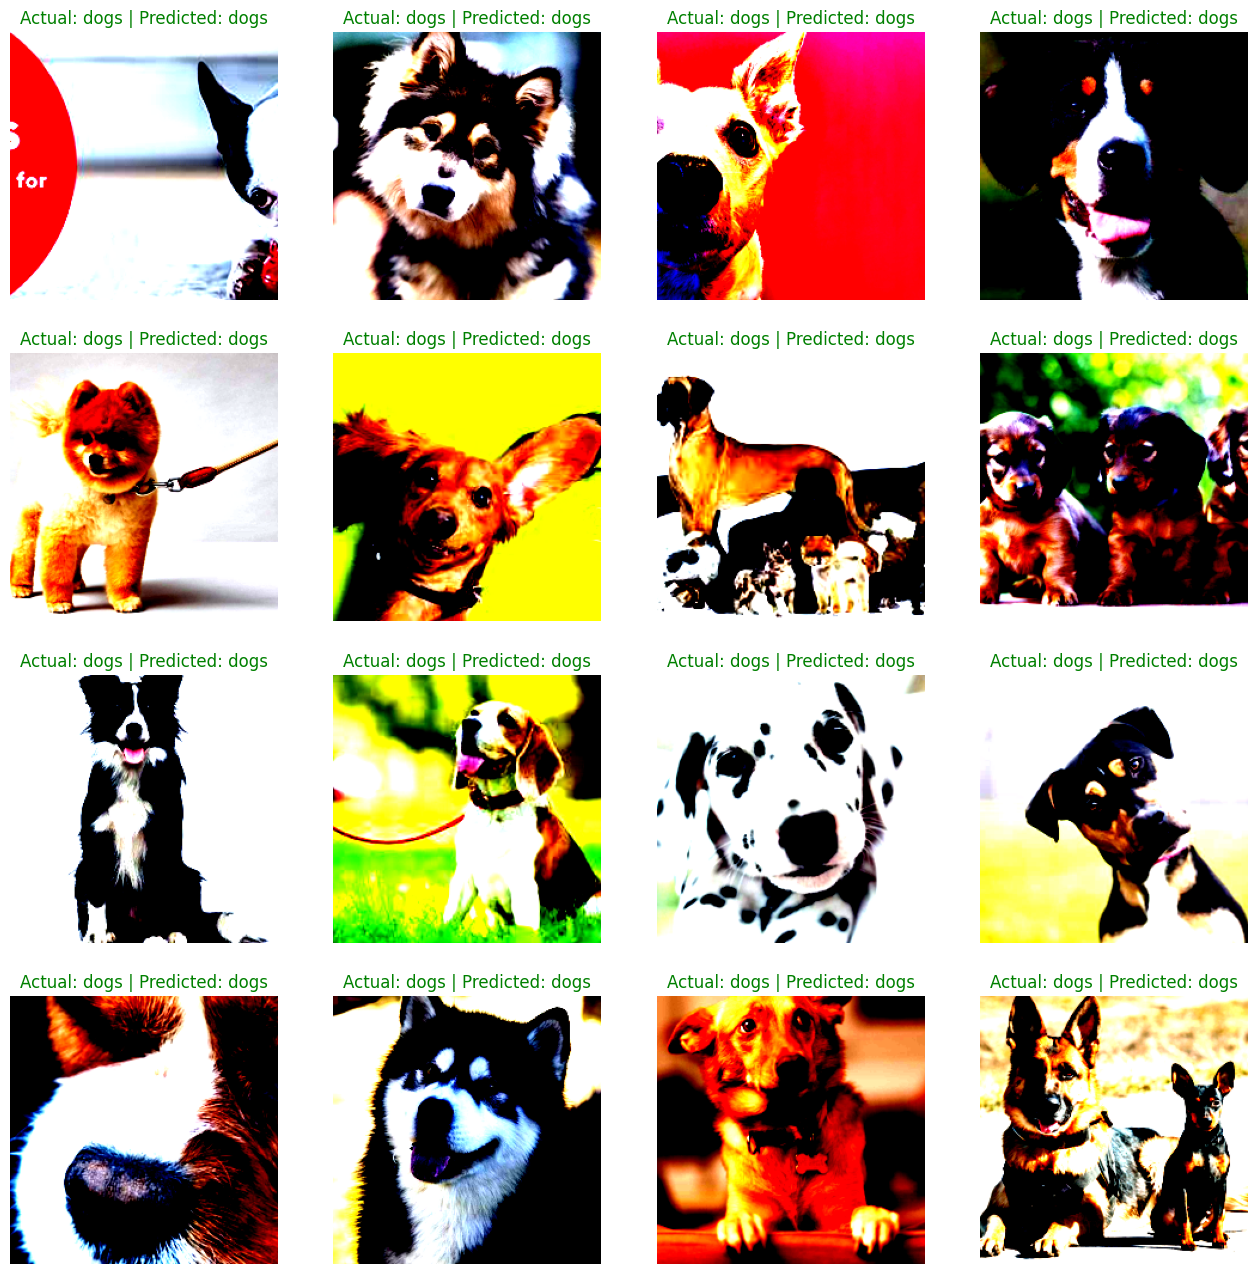

In [129]:
plot_random_batch(model, test_loader, class_names)

## 10. Saving and loading the model

In [130]:
# Saving the model

# Create directory to save the model
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(exist_ok=True)

# Save the model
torch.save(model.state_dict(), MODEL_PATH / "cats-dogs-resnet50.pth")

In [131]:
# Loading the model
model = models.resnet50()
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, len(class_names))
model.load_state_dict(torch.load(MODEL_PATH / "cats-dogs-resnet50.pth"))
model.to(device)
summary(model, input_size=(BATCH_SIZE, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [32, 2]                   --
├─Conv2d: 1-1                            [32, 64, 112, 112]        9,408
├─BatchNorm2d: 1-2                       [32, 64, 112, 112]        128
├─ReLU: 1-3                              [32, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [32, 64, 56, 56]          --
├─Sequential: 1-5                        [32, 256, 56, 56]         --
│    └─Bottleneck: 2-1                   [32, 256, 56, 56]         --
│    │    └─Conv2d: 3-1                  [32, 64, 56, 56]          4,096
│    │    └─BatchNorm2d: 3-2             [32, 64, 56, 56]          128
│    │    └─ReLU: 3-3                    [32, 64, 56, 56]          --
│    │    └─Conv2d: 3-4                  [32, 64, 56, 56]          36,864
│    │    └─BatchNorm2d: 3-5             [32, 64, 56, 56]          128
│    │    └─ReLU: 3-6                    [32, 64, 56, 56]          --
│ 

## 11. Getting custom image and predicting

In [137]:
import torchvision.transforms.functional as TF

def pred_and_plot_image(model: nn.Module,
                        image_path: str,
                        device: str,
                        class_names: List[str],
                        transform=None) -> None:
    # Carrega a imagem como PIL Image
    target_image = Image.open(image_path)

    # Aplica as transformações
    if transform:
        target_image = transform(target_image)
    else:
        # Converta para tensor e normalize aqui se nenhuma transformação foi fornecida
        target_image = TF.to_tensor(target_image)
        target_image = TF.normalize(target_image, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

    # Certifica que a imagem e o modelo estão no mesmo dispositivo
    model.to(device)
    target_image = target_image.to(device)

    model.eval()
    with torch.inference_mode():
        # Adiciona a dimensão de lote
        target_image = target_image.unsqueeze(0)

        # Passo forward
        target_image_preds = model(target_image)

        # Converta logits para probabilidades
        target_image_probs = nn.functional.softmax(target_image_preds, dim=1)

        # Pega a classe com maior probabilidade
        target_image_preds_argmax = target_image_preds.argmax().cpu()

        # Plota a imagem
        plt.imshow(target_image[0].permute(1, 2, 0).cpu())
        if class_names:
            plt.title(f"Prediction: {class_names[target_image_preds_argmax]} | Probability: {target_image_probs.max().item():.3f}")
        else:
            plt.title(f"Prediction: {target_image_preds_argmax.cpu()} | Probability: {target_image_probs.max().item():.3f}")

        plt.axis(False)
        plt.show()

# Agora a função está ajustada para trabalhar com a imagem como PIL Image e depois convertê-la para tensor dentro da condição de transformação.


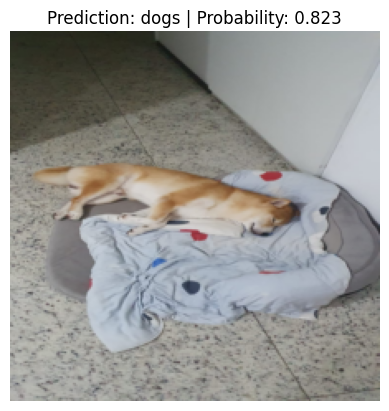

In [143]:
custom_image_path = DATAPATH / "dog.jpeg"
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),   
])
pred_and_plot_image(model, custom_image_path, device, class_names, simple_transform)